In [1]:
import copy
import math

from Utilities import *
from PuzzlePiece import *
from AlignerTools import *

In [2]:
# gather all the pieces
target_pieces = {}
tried_pieces = {}

for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    target_pieces[p] = PuzzlePiece('3x3_pieces/' + p + '_border.csv', border_sampling_rate=.2)

In [3]:
# get the first piece
query = target_pieces.pop('C') # this piece serves as the core
tried_pieces['C'] = copy.deepcopy(query) # keep a copy in case we need to go back 

In [14]:
###############################
# REPEAT HERE
##############################
print(target_pieces.keys())

dict_keys(['E', 'SE', 'S', 'SW', 'W', 'NW'])


In [15]:
# find the closest match in the other pieces
mx_score = 0
mx_piece = ''

alignments = {}

for i,p in enumerate(target_pieces):
    
    target = target_pieces[p]
    
    # extend the query to account for circular sequence
    tail_length = min(int(len(target_pieces[p].border_sample) * .10),
                  int(len(query.border_sample) * .10))

    query.extend_border_sample(tail_length)
    target.extend_border_sample(tail_length, reverse = True)
    
    # get the full pairwise matrix to establish the cutoff value
    DistMatrix, mx, mx_Q, mx_T, length = \
        AlignPiecesEuclid(query.border_sample_ext, 
                           target.border_sample_ext, window = 5)
    
    sims = []
    for i in range(1,len(DistMatrix)):
        for j in range(1,len(DistMatrix[i])):
            sims.append(DistMatrix[i][j])

    sims.sort()
    cutoff = sims[int(len(sims)*.01)]
    
    # Build suffix table from the distance matrix
    distr_score = False
    av = 25
    sd = 5
    
    diy_mx = 0.0
    diy_mx_Q = 0
    diy_mx_T = 0
    
    DIYSuffTable = [[0 for k in range(len(target.border_sample_ext)+1)] 
                       for l in range(len(query.border_sample_ext)+1)] 
    cutoff_multiplier = 2 # penalty for extended ranges outsisde cutoff
    for i in range(len(query.border_sample_ext) + 1): 
        for j in range(len(target.border_sample_ext) + 1): 
            if (i == 0 or j == 0): 
                DIYSuffTable[i][j] = 0
            else:
                d = DistMatrix[i][j]
                if distr_score:
                    qtile = (d-av)/sd
                    if qtile > 0:
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] - qtile * cutoff_multiplier
                        cutoff_multiplier *= 2
                    else:
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] - qtile
                        cutoff_multiplier = 2
                else:
                    if d < cutoff: # small distance improve our score
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] + 1
                        cutoff_multiplier = 1
                    else: #large distances degrade our score
                        DIYSuffTable[i][j] = DIYSuffTable[i-1][j-1] - cutoff_multiplier
                        cutoff_multiplier *= 2
                DIYSuffTable[i][j] = max(0,DIYSuffTable[i][j])

                if DIYSuffTable[i][j] > diy_mx:
                    diy_mx = DIYSuffTable[i][j]
                    diy_mx_Q = i
                    diy_mx_T = j
    
    # determine the length of the best scoring window
    diy_length = 1
    for diy_length in range( 1, min(diy_mx_Q,diy_mx_T)+1 ):
        if DIYSuffTable[diy_mx_Q-diy_length][diy_mx_T-diy_length] == 0:
            break
    diy_length += 1
    
    alignments[p] = { 'SuffTable': DIYSuffTable,
                      'mx_score': diy_mx,
                      'mx_Q': diy_mx_Q,
                      'mx_T': diy_mx_T,
                      'length': diy_length,
                      'cutoff': cutoff}
    
    if diy_mx > mx_score:
        mx_score = diy_mx
        mx_piece = p
        
    print(p, diy_mx)

E 21
SE 7
S 0.0
SW 0.0
W 28
NW 27


In [16]:
mx_piece_rev = { i:target_pieces[mx_piece].border_sample[i]
                    for i in list(target_pieces[mx_piece].border_sample.keys())[::-1] }

mx_alignment = alignments[mx_piece]
SuffTable = mx_alignment['SuffTable']
mx = mx_alignment['mx_score']
mx_Q = mx_alignment['mx_Q']
mx_T = mx_alignment['mx_T']
length = mx_alignment['length']
cutoff = mx_alignment['cutoff']

target = target_pieces.pop(mx_piece)
print('Best: ', mx_piece, mx, mx_Q, mx_T, length)

Best:  W 28 220 189 29


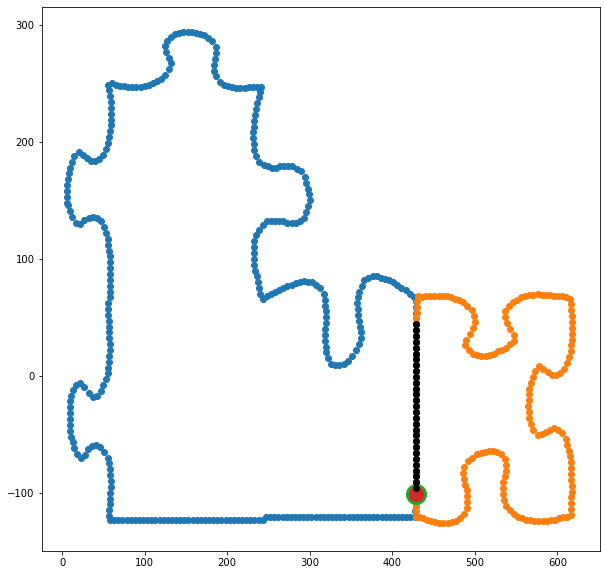

In [17]:
#find the best matched point - this is the end of the best match window
Q_pt = query.border_sample[query.ext_to_old_index[mx_Q]]
T_pt = target.border_sample[target.ext_to_old_index[mx_T]]

# find x,y shift to align pieces based on that one point
T_xshift = T_pt['x'] - Q_pt['x']
T_yshift = T_pt['y'] - Q_pt['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.border_sample[k]['x'] for k,v in query.border_sample.items() ],
             [query.border_sample[k]['y'] for k,v in query.border_sample.items() ])
plt.scatter( [target.border_sample[k]['x'] - T_xshift for k,v in target.border_sample.items() ],
             [target.border_sample[k]['y'] - T_yshift for k,v in target.border_sample.items() ])

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt['x'], Q_pt['y'], s=400)
plt.scatter( T_pt['x'] - T_xshift, T_pt['y'] - T_yshift, s=196 ) 

# show similarity window
# the black and grey points repsent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points

Q_window = [query.border_sample[query.ext_to_old_index[q]] for q in range(mx_Q-length, mx_Q)]
plt.scatter( [p['x'] for p in Q_window],
             [p['y'] for p in Q_window], c = 'grey' )

T_window = [target.border_sample[target.ext_to_old_index[t]] for t in range(mx_T - length, mx_T)]
plt.scatter( [p['x'] - T_xshift for p in T_window],
             [p['y'] - T_yshift for p in T_window], c = 'black' )

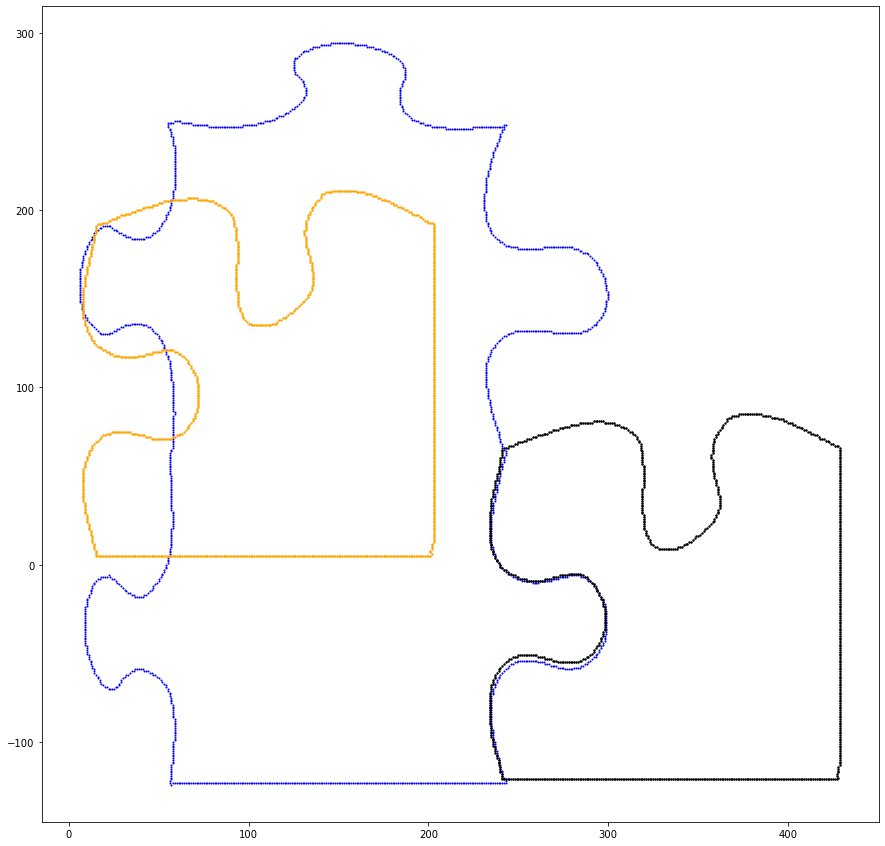

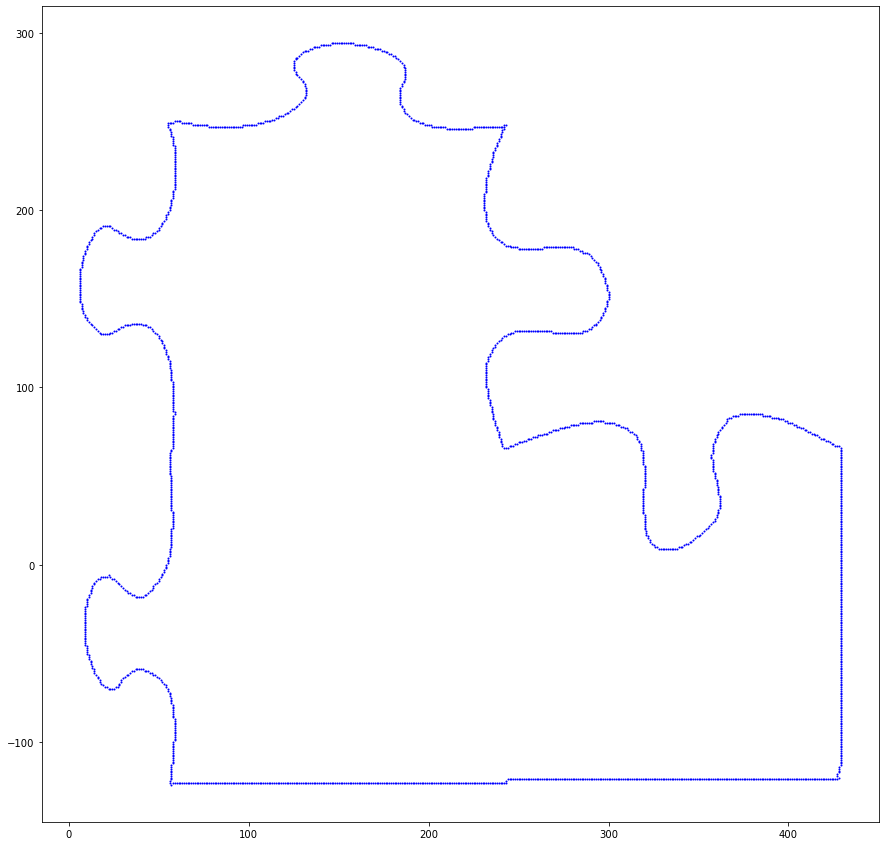

In [13]:
# combine the pieces into one piece
Q_window_pts = [q for q in range(mx_Q-length, mx_Q)]
T_window_pts = [t for t in range(mx_T-length, mx_T)]

Q_x = [ q[1]['x'] for q in query.border.items() ]
Q_y = [ q[1]['y'] for q in query.border.items() ]

T_orig_x = [ t[1]['x'] for t in target.border.items() ]
T_orig_y = [ t[1]['y'] for t in target.border.items() ]

target.reposition(T_window_pts, query, Q_window_pts)

T_shifted_x = [t[1]['x'] for t in target.border.items() ]
T_shifted_y = [t[1]['y'] for t in target.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_x, Q_y, c = 'blue', s=1)
plt.scatter( T_orig_x, T_orig_y, c = 'orange', s=2)
plt.scatter( T_shifted_x, T_shifted_y, c = 'black', s=2)

query.merge(target)

Q_merged_x = [ q[1]['x'] for q in query.border.items() ]
Q_merged_y = [ q[1]['y'] for q in query.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_merged_x, Q_merged_y, c = 'blue', s=1)


In [ ]:
#########################
# REPEAT ABOVE
#########################